In [1]:
import time

import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.integrate import solve_ivp
from sklearn.preprocessing import StandardScaler, MinMaxScaler

print(torch.cuda.is_available())
print(torch.cuda.get_device_name() if torch.cuda.is_available() else "no gpu")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

False
no gpu


device(type='cpu')

In [2]:
seed = 1234
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load simple ODE


In [2]:
def hysteresis_ode(t,x,lam):
    return lam+x-x**3

def simulate_branch(lam_values, x0):
    x_vals = []
    x_curr = x0
    for lam in tqdm(lam_values):
        sol = solve_ivp(hysteresis_ode, [0, 50], [x_curr], args=(lam,), t_eval=[50])
        x_curr = sol.y[0, -1]  # final value
        x_vals.append(x_curr)
    return np.array(x_vals)

In [3]:
lam_start = -1 
lam_end = 1

lam_up = np.linspace(lam_start, lam_end, 250)
lam_down = np.linspace(lam_end, lam_start, 250)

In [4]:
x0=-1
x_increase = simulate_branch(lam_up, x0)
x_decrease = simulate_branch(lam_down,x_increase[-1])

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

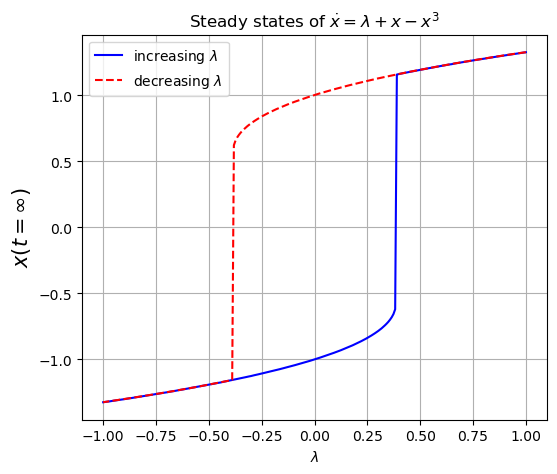

In [5]:

fig, ax = plt.subplots(1,1, figsize = (6,5))

ax.plot(lam_up, x_increase, c='blue', label=r'increasing $\lambda$')
ax.plot(lam_down, x_decrease, c='red', linestyle="--", label=r'decreasing $\lambda$')
ax.grid(True)
ax.set_xlabel(r"$\lambda$")
ax.set_ylabel(r"$x(t = \infty)$",size = 15)
ax.set_title("Steady states of "+r"$\dot{x} = \lambda + x - x^3$")
ax.legend()
plt.show()

In [6]:
X = np.hstack((x_increase, x_decrease))
X = np.hstack((X,X))

lam_vals  = np.hstack((lam_up,lam_down))
lam_vals = np.hstack((lam_vals,lam_vals))

scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(-1,1))
X.shape
X = scaler.fit_transform(X.reshape(-1,1))

t_train = np.arange(0,len(X),5)
X_train = X[t_train]
lam_train = lam_vals[t_train]

In [7]:

X.max()

1.0

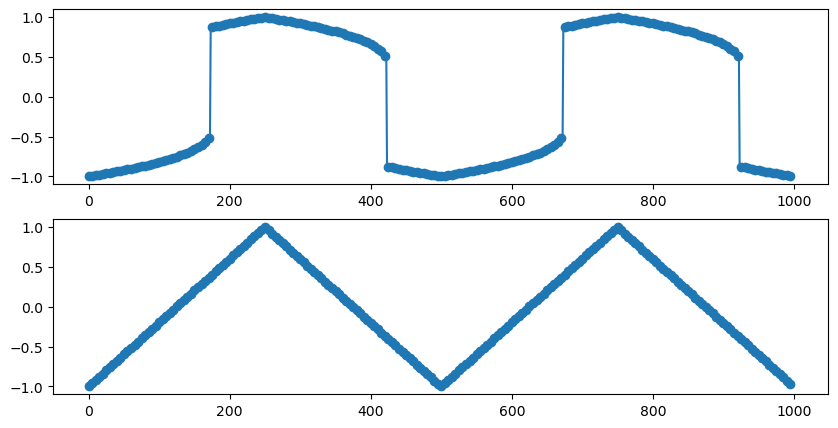

In [8]:
fig, ax = plt.subplots(2,1,figsize=(10,5))
ax[0].plot(X)
ax[0].scatter(t_train,X_train)
ax[1].plot(lam_vals)
ax[1].scatter(t_train,lam_train)
plt.show()

# Neuro ODE approach

In [9]:
import numpy as np

import torch 
import torch.nn as nn
from torchdiffeq import odeint

In [10]:
def lam_func(t):
    lam_vals = np.hstack((lam_up,lam_down))
    idx = int(t) % len(lam_vals)
    return torch.tensor(lam_vals[idx], dtype=torch.float32, device=device)

In [11]:
class FTerm(nn.Module):
    def __init__(self,dim_in, dim_out, hidden_dim = 4):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_in, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, dim_out),
            nn.Tanh(),
        )
    def forward(self,x):
        return - torch.exp(self.network(x))


class GTerm(nn.Module):
    def __init__(self, dim_in, dim_out, hidden_dim = 4):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_in, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, dim_out),
            nn.Tanh(),
        )

    def forward(self, x, u):
        xu = torch.cat([x,u],dim=-1)
        return self.network(xu)


class ODEModel(nn.Module):
    def __init__(self,f,g):
        super().__init__()
        self.f = f
        self.g = g

    def forward(self, t, state, u_func):
        x = state
        u = u_func(t).unsqueeze(0).unsqueeze(1)
        fx = self.f(x)
        gx = self.g(x,u)
        return fx*(x-gx)

In [12]:

x_true = torch.tensor(X, dtype=torch.float32,device=device)
x0 = torch.tensor([[x_true[0]]],requires_grad = True, device=device)
dim_in = 1
dim_out = 1
f = FTerm(dim_in, dim_out).to(device)
g = GTerm(2, dim_out).to(device)

ode_model = ODEModel(f,g).to(device)


In [13]:
t_span = torch.arange(1000,dtype=torch.float32,device=device)

In [14]:
lam_func(t_span[0])

tensor(-1.)

In [15]:
t0 = time.time()
# non-adaptive method is much faster
# see what is being used in neuromancer
method='rk4'
x_pred = odeint(lambda t, x: ode_model(t,x,lam_func),x0,t_span, method =method)
print(time.time()-t0)

0.8885929584503174


In [16]:
x_pred.squeeze().shape, X.squeeze().shape

(torch.Size([1000]), (1000,))

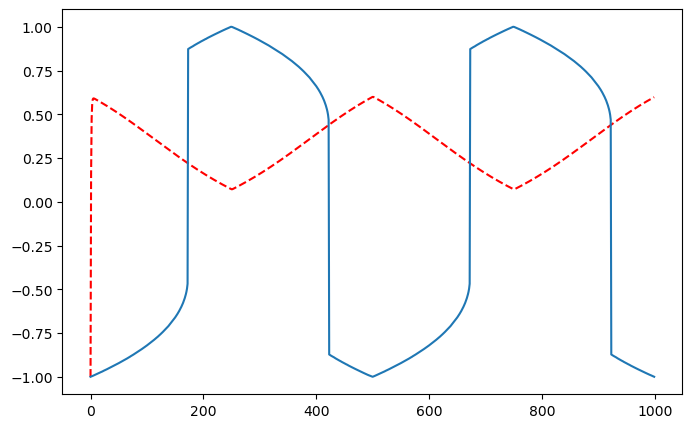

In [17]:
fig, ax = plt.subplots(1,1, figsize=(8,5))

ax.plot(x_pred.squeeze().detach().cpu().numpy(), linestyle='--',c='red')
ax.plot(x_true.squeeze().detach().cpu().numpy(),)
plt.show()


In [18]:

x_true.squeeze().max()

tensor(1.)

In [19]:
# about 46-1hr
loss_criteria = nn.MSELoss()
opt = torch.optim.Adam(list(f.parameters())+list(g.parameters()), lr=1e-2)
n_epochs = 200

for epoch in tqdm(range(n_epochs)):
    t1 = time.time()
    opt.zero_grad()
    x_pred = odeint(lambda t, x: ode_model(t,x,lam_func), x0, t_span, method='rk4')
    loss = loss_criteria(x_pred.squeeze(), x_true.squeeze())
    loss.backward()
    opt.step()
    t2 = time.time()
    print(f"Epoch {epoch}: Loss = {loss.item():.4f}, time = {t2-t1:.4f} s.")
    

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0: Loss = 1.1194, time = 2.0414 s.
Epoch 1: Loss = 1.0901, time = 1.9647 s.
Epoch 2: Loss = 1.0624, time = 2.0290 s.
Epoch 3: Loss = 1.0364, time = 2.0522 s.
Epoch 4: Loss = 1.0122, time = 2.2086 s.
Epoch 5: Loss = 0.9899, time = 2.0776 s.
Epoch 6: Loss = 0.9693, time = 2.0732 s.
Epoch 7: Loss = 0.9505, time = 2.0998 s.
Epoch 8: Loss = 0.9333, time = 2.0959 s.
Epoch 9: Loss = 0.9175, time = 2.1998 s.
Epoch 10: Loss = 0.9031, time = 2.0779 s.
Epoch 11: Loss = 0.8898, time = 2.0789 s.
Epoch 12: Loss = 0.8776, time = 2.0729 s.
Epoch 13: Loss = 0.8662, time = 2.2035 s.
Epoch 14: Loss = 0.8557, time = 2.0779 s.
Epoch 15: Loss = 0.8458, time = 2.0720 s.
Epoch 16: Loss = 0.8365, time = 2.0911 s.
Epoch 17: Loss = 0.8277, time = 2.2180 s.
Epoch 18: Loss = 0.8194, time = 2.1130 s.
Epoch 19: Loss = 0.8114, time = 2.1122 s.
Epoch 20: Loss = 0.8038, time = 2.1061 s.
Epoch 21: Loss = 0.7965, time = 2.0814 s.
Epoch 22: Loss = 0.7894, time = 2.2252 s.
Epoch 23: Loss = 0.7825, time = 2.0720 s.
Ep

In [20]:


# x_pred = odeint(lambda t, x: ode_model(t,x,lam_func), x0, t_span,method='rk4')



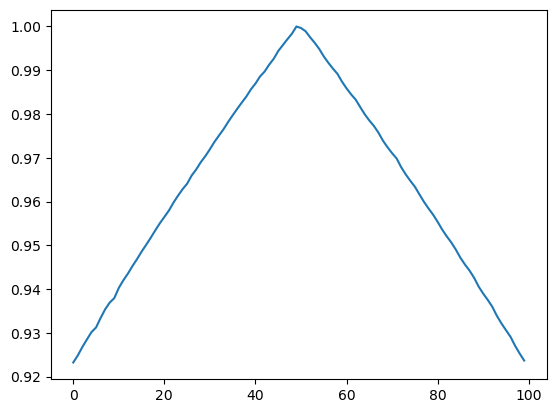

In [22]:
plt.plot(x_true[200:300])

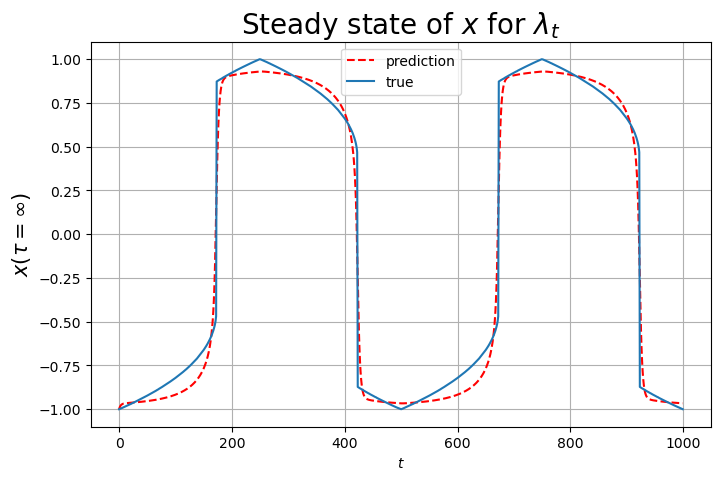

In [23]:
fig, ax = plt.subplots(1,1, figsize=(8,5))


ax.plot(x_pred.squeeze().detach().cpu().numpy(), linestyle='--',c='red', label='prediction')
ax.plot(x_true,label='true')
ax.set_xlabel(r'$t$',size=10)
ax.set_ylabel(r'$x(\tau=\infty)$',size=15)
ax.set_title(r"Steady state of $x$ for $\lambda_t$", size=20)
ax.grid(True)
ax.legend()
plt.savefig(f"epochs_{n_epochs}_scaled_data.png")
plt.show()

### save results

In [24]:
f_cpu = f.to('cpu')
g_cpu = g.to('cpu')
ode_model_cpu = ODEModel(f_cpu, g_cpu)

In [25]:
save_path = f"full_gd_lr_01_epoch_{n_epochs}_scaled_data.pt"

torch.save({"f_state_dict": f_cpu.state_dict(),
           "g_state_dict": g_cpu.state_dict(),
           "ode_model_state_dict": ode_model_cpu.state_dict()}, save_path)

f.to(device)
g.to(device)

GTerm(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): Tanh()
    (2): Linear(in_features=4, out_features=1, bias=True)
    (3): Tanh()
  )
)

In [26]:
g

GTerm(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): Tanh()
    (2): Linear(in_features=4, out_features=1, bias=True)
    (3): Tanh()
  )
)

In [23]:
def g_true(x,lam):
    return (1/x)*(lam/x+1)

In [24]:
g.eval()

g_out = []
g_true_out = []
for idx in range(len(x_true)):
    xi = x_true[idx]
    xi = torch.tensor([[xi]],dtype =torch.float32,device=device)

    lami = lam_vals[idx]
    lami = torch.tensor([[lami]],dtype=torch.float32,device=device)

    with torch.no_grad():
        g_out.append(g(xi,lami).detach().cpu().numpy())

    g_true_out.append(g_true(xi,lami).detach().cpu().numpy())
    

In [33]:
x_true

tensor([[-1.0000],
        [-0.9988],
        [-0.9975],
        [-0.9962],
        [-0.9948],
        [-0.9931],
        [-0.9916],
        [-0.9903],
        [-0.9891],
        [-0.9873],
        [-0.9858],
        [-0.9844],
        [-0.9832],
        [-0.9815],
        [-0.9798],
        [-0.9784],
        [-0.9772],
        [-0.9757],
        [-0.9738],
        [-0.9723],
        [-0.9710],
        [-0.9697],
        [-0.9678],
        [-0.9661],
        [-0.9647],
        [-0.9633],
        [-0.9615],
        [-0.9598],
        [-0.9583],
        [-0.9569],
        [-0.9553],
        [-0.9535],
        [-0.9520],
        [-0.9506],
        [-0.9489],
        [-0.9471],
        [-0.9455],
        [-0.9441],
        [-0.9425],
        [-0.9405],
        [-0.9389],
        [-0.9374],
        [-0.9359],
        [-0.9338],
        [-0.9321],
        [-0.9305],
        [-0.9290],
        [-0.9270],
        [-0.9252],
        [-0.9236],
        [-0.9220],
        [-0.9200],
        [-0.

In [32]:
xi, lami

(tensor([[-0.9999]]), tensor([[-1.]]))

In [25]:
g_out = np.array(g_out).reshape(-1)

In [26]:
g_true_out = np.array(g_true_out).reshape(-1)
g_true_out.shape

(1000,)

In [30]:
g

GTerm(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): Tanh()
    (2): Linear(in_features=4, out_features=1, bias=True)
    (3): Tanh()
  )
)

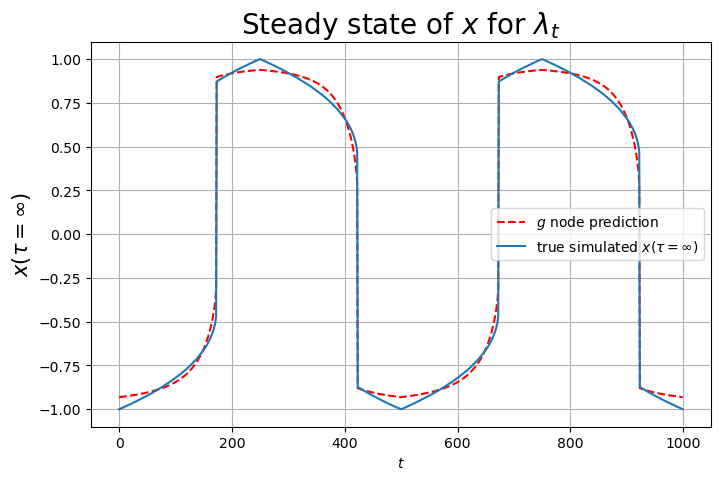

In [29]:
fig, ax = plt.subplots(1,1,figsize=(8,5))

# ax.plot(g_true_out,c='black', label=r'true $g$')
ax.plot(t_span.detach().cpu().numpy(),g_out,c='red', linestyle="--", label=r"$g$ node prediction")
ax.plot(x_true.squeeze().detach().cpu().numpy(),label=r'true simulated $x(\tau=\infty)$')
# ax.plot(x_pred.squeeze().detach().cpu().numpy(), linestyle='--',c='red', label='prediction')

ax.set_xlabel(r'$t$',size=10)
ax.set_ylabel(r'$x(\tau=\infty)$',size=15)
ax.set_title(r"Steady state of $x$ for $\lambda_t$", size=20)
ax.grid(True)
ax.legend()
plt.savefig(f"epochs_{n_epochs}.png")

plt.show()